In [1]:
import mido
from mido import MidiFile
import numpy as np
import copy

HEARING_PORT = mido.open_output()
np.set_printoptions(threshold=np.nan)

In [2]:
class Song:
    def __init__(self, name):
        self.name = name
        self.correct = True
        self.notes = np.zeros((128, 13), dtype=int)#-np.ones((128, 13))
        
        if isinstance(name, str):        
            maxnote = 0
            minnote = 127
            for msg in MidiFile(name):
                if (msg.type == "note_on" and msg.velocity > 0):
                    if msg.note < minnote:
                        minnote = msg.note
                    if msg.note > maxnote:
                        maxnote = msg.note
            if maxnote - minnote >= 13:
                print("ERROR! out of range!")
                self.correct = False
                return

            shift = 0
            if minnote < 60:
                shift = 60 - minnote
            if maxnote >= 60 + 13:
                shift = 60 + 13 - 1 - maxnote

            absolute_time_passed = 0
            for msg in MidiFile(name):
                absolute_time_passed += msg.time

                if (msg.type == "note_on" and msg.velocity > 0):
                    self.notes[round(absolute_time_passed / 0.25)][msg.note - 60 + shift] = 1
        else:
            for i, note in enumerate(name):
                if note >= 0 and note < 13:
                    self.notes[i][note] = 1
                
    def play(self):
        for msg in MidiFile(self.name).play():
            HEARING_PORT.send(msg)
            
    def transpose(self, shift):
        if (not self.correct or
           (shift > 0 and self.notes[:, -shift:].sum() != 0) or
           (shift < 0 and self.notes[:, :-shift].sum() != 0)):
            return False
        
        self.notes = np.hstack([self.notes[:, -shift:], self.notes[:, :-shift]])
        return True

In [3]:
class MySong:
    def __init__(self, played_lines=[]):
        self.notes = np.zeros((0, 13))
        
        self.mid = MidiFile()
        self.track = mido.MidiTrack()
        self.mid.tracks.append(self.track)
        
        self.time_passed = 0
        self.release = []
        
        for line in played_lines:
            self.add(line)
        
    def add(self, played):
        self.notes = np.vstack([self.notes, played])

        for i in self.release:        
            self.track.append(mido.Message('note_off', note=60+i, velocity=64, time=self.time_passed))
            self.time_passed = 0
        self.release = []

        for i, key in enumerate(played):
            if key == 1:
                self.track.append(mido.Message('note_on', note=60+i, velocity=64, time=self.time_passed))
                self.time_passed = 0
                self.release.append(i)
        self.time_passed += 256
    
    def finish(self):
        for i in self.release:        
            self.track.append(mido.Message('note_off', note=60+i, velocity=64, time=self.time_passed))
            self.time_passed = 0
        self.track.append(mido.Message('note_off', note=60, velocity=0, time=self.time_passed))
        
    def play(self):
        for msg in self.mid.play():
            HEARING_PORT.send(msg)
            
    def save_file(self, name):
        self.mid.save(name + '.mid')

# ОКИ

In [4]:
import numpy as np
from numpy import random

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
MEMORY_TIMES = 64
STARTER = 8

ADDITIONAL_MEMORY = 8

MEMORY_SIZE = MEMORY_TIMES * 13 + ADDITIONAL_MEMORY

In [6]:
NOTE_NAMES = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B", "C^"]
NAMES = []
for i in range(8):
    NAMES.append("[tb" + str(i) + "]")
for t in range(-MEMORY_TIMES, 0):
    for note_name in NOTE_NAMES:
        NAMES.append(note_name + str(t))

In [7]:
class Func:
    def __init__(self, Random):
        self.operands = np.zeros((0, MEMORY_SIZE))
        self.thresholds = np.array([])
        self.max_thresholds = np.array([])
        self.zeros = np.zeros((1, MEMORY_SIZE))
        
        self.Random = Random
        
    def apply(self, x):       
        return (self.operands.dot(x) >= self.thresholds).any()
    
    def add_positive(self, memory):        
        current_result = self.operands.dot(memory)
        M = memory.sum()
        for i, val in enumerate(current_result):
            if val >= self.thresholds[i] and val < M:
                new_obj = np.logical_or(self.operands[i], memory)
                new_thr = self.zeros.dot(new_obj).max() + 1
                new_max_thr = min(self.max_thresholds[i], memory.sum())
                
                if new_thr <= new_max_thr:
                    self.operands = np.vstack([self.operands, new_obj])
                    self.thresholds = np.append(self.thresholds, new_thr)
                    self.max_thresholds = np.append(self.max_thresholds, new_max_thr)
        
        self.operands = np.vstack([self.operands, memory])
        self.thresholds = np.append(self.thresholds, self.zeros.dot(memory).max() + 1)
        self.max_thresholds = np.append(self.max_thresholds, memory.sum())
        
    def add_negative(self, memory):
        self.zeros = np.vstack([self.zeros, memory])
        
        self.thresholds = np.maximum(self.thresholds, self.operands.dot(memory) + 1)
        
        remove = (self.thresholds > self.max_thresholds).nonzero()[0]
        self.operands = np.delete(self.operands, remove, 0)
        self.thresholds = np.delete(self.thresholds, remove)
        self.max_thresholds = np.delete(self.max_thresholds, remove)
    
    def print(self):
        print("0", end="")
        for oper, t, mt in zip(self.operands, self.thresholds, self.max_thresholds):
            print(" ∨ ", end="")
            for i in range(MEMORY_SIZE):
                if oper[i]:
                    print(NAMES[i], end="")
            print("(", t, " / ", mt, ")")
        print("")

In [8]:
class Player:
    def __init__(self):
        self.Random = np.random.RandomState(seed=179)
        self.play_note = [Func(self.Random) for i in range(13)]
        
    def play(self, memory):
        return np.array([self.play_note[i].apply(memory) for i in range(13)], dtype=int)
    
    def learn_to_play(self, song_to_learn, verbose=False):
        memory = np.zeros((MEMORY_SIZE), dtype=int)
        memory[-STARTER*13:] = song_to_learn.notes[:STARTER].flatten()

        t = STARTER
        memory[t % 8] = 1
        errors = 0
        
        verbose_data = [[] for i in range(13)]
        
        while t < len(song_to_learn.notes):    
            output = self.play(memory)
                       
            for note in range(13):    
                if output[note] != song_to_learn.notes[t][note]:
                    errors += 1
                    
                if song_to_learn.notes[t][note] == 1:
                    self.play_note[note].add_positive(memory)
                else:
                    self.play_note[note].add_negative(memory)
                    
            if verbose:
                for note in range(13):
                    verbose_data[note].append(len(self.play_note[note].operands))

            memory = np.concatenate([np.zeros((ADDITIONAL_MEMORY)), memory[ADDITIONAL_MEMORY + 13:], song_to_learn.notes[t]])
            t += 1
            memory[t % 8] = 1
        
        if verbose:            
            print("Num of Errors: ", errors)
            
            for note in range(13):
                plt.plot(verbose_data[note], label=NOTE_NAMES[note])
            plt.legend()
            plt.show()
        return errors
    
    def improvise(self, starter, length=128):
        memory = np.zeros((MEMORY_SIZE), dtype=int)
        memory[-STARTER*13:] = starter.notes[:STARTER].flatten()

        result = MySong(starter.notes[:STARTER])
        
        t = STARTER
        memory[t % 8] = 1
        while t < length:    
            output = player.play(memory)
            result.add(output)

            memory = np.concatenate([np.zeros((ADDITIONAL_MEMORY)), memory[ADDITIONAL_MEMORY + 13:], output])
            t += 1
            memory[t % 8] = 1
        result.finish()
        
        return result

## Обучение

Создаём нового игрока и грузим пока кузнечика

In [10]:
player = Player()

In [11]:
kuznechik = Song('test/track (1).mid')

Num of Errors:  58


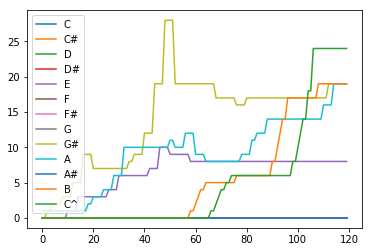

58

In [12]:
player.learn_to_play(kuznechik, True)

Проверим, что всё окей. Подадим на вход начало кузнечика, а дальше пусть играет сам (память занимается тем, что игрок сам нажимает на рояле). Поскольку так заданы правила, кузнечик будет воспроизведён точно

In [13]:
player.improvise(kuznechik).play()

KeyboardInterrupt: 

Вот как выглядит его булево правило:

In [14]:
player.play_note[4].print()

0 ∨ [tb2]A-18E-16A-14E-12A-10G#-8G#-6G#-2( 6.0  /  9.0 )
 ∨ [tb2][tb6]A-22E-20A-18E-16A-14E-12G#-12G#-10A-10G#-8G#-6E-4G#-2( 9.0  /  9.0 )
 ∨ [tb6]A-22E-20A-18E-16A-14G#-12G#-10G#-6E-4G#-2( 8.0  /  11.0 )
 ∨ [tb2]A-34E-32A-30E-28A-26G#-24G#-22G#-18E-16G#-14E-12G#-10A-8A-6A-2( 16.0  /  16.0 )
 ∨ [tb6]A-38E-36A-34E-32A-30G#-28G#-26G#-22E-20G#-18E-16G#-14A-12A-10A-6E-4A-2( 16.0  /  18.0 )
 ∨ [tb2]A-50E-48A-46E-44A-42G#-40G#-38G#-34E-32G#-30E-28G#-26A-24A-22A-18E-16A-14E-12A-10G#-8G#-6G#-2( 16.0  /  23.0 )
 ∨ [tb2][tb6]A-54E-52A-50E-48A-46E-44G#-44G#-42A-42G#-40G#-38E-36G#-34E-32G#-30E-28A-28G#-26A-26A-24A-22E-20A-18E-16A-14E-12G#-12G#-10A-10G#-8G#-6E-4G#-2( 17.0  /  23.0 )
 ∨ [tb6]A-54E-52A-50E-48A-46G#-44G#-42G#-38E-36G#-34E-32G#-30A-28A-26A-22E-20A-18E-16A-14G#-12G#-10G#-6E-4G#-2( 16.0  /  25.0 )



Окей, чтобы услышать что-то новое, нужно другое начало. Возьмём его из другой песенки

In [15]:
simple_song = Song('test/track (2).mid')
result = player.improvise(simple_song)

Первый шедевр:

In [ ]:
result.play()

Игрок пока использует только несколько нот. Просто в кузнечике есть не все 13 нот, так что мы можем его посмещать, чтобы получить новую информацию. Попробуем сместить кузнечика на одну ноту

In [9]:
player = Player()

In [10]:
def addAllTransposedVersions(Songs, song):
    while song.transpose(1):
        pass

    Songs.append(copy.deepcopy(song))
    while song.transpose(-1):
        Songs.append(copy.deepcopy(song))

In [11]:
Songs = []
for i in range(1, 35):
    addAllTransposedVersions(Songs, Song('test/track (' + str(i) + ').mid'))

ERROR! out of range!
ERROR! out of range!
ERROR! out of range!


In [12]:
import random
random.shuffle(Songs)

In [13]:
for song in Songs:
    errors = player.learn_to_play(song)
    print(errors)

60
81
46
42
35
25
58
33
34
23
50
56
35
42
49
41
52
48
44
32
81
42
37
59
46
44
45
45
61
54
51
0
53
72
85
83
54
35
43
56
27
42
45
22
42
57
52
51
44
61
48
21
56
31
51
0
61
41
86
48
42
55
59
44
38
52
51
55
0


In [14]:
simple_song = Song('test/whomadethis.mid')
result = player.improvise(simple_song)
result.play()

In [45]:
result.save_file("10. ")

In [15]:
simple_song = Song([0, -1, 5, -1, 4, -1, 5, -1])
result = player.improvise(simple_song)
result.play()

In [16]:
simple_song = Song([0, -1, 5, -1, 4, -1, 7, -1])
result = player.improvise(simple_song)
result.play()